In [9]:
import numpy as np
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.table import Table
from scipy.interpolate import griddata
from photutils.aperture import *
from scipy.ndimage import gaussian_filter
from scipy.spatial import *
from sklearn.neighbors import KDTree
from astropy.table import Table
from astropy.table import vstack as vstack_table

from skimage.restoration import denoise_tv_bregman
from scipy.signal import convolve2d
from scipy.spatial import Delaunay
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
from scipy.spatial import ConvexHull
import itertools


from astropy.modeling.models import Gaussian2D
from skimage import color, data, restoration
from mpl_toolkits.axes_grid1 import make_axes_locatable


import re
from os import path
from astropy.nddata import Cutout2D
from reproject import reproject_interp
from collections import Counter
from image_registration import chi2_shift
from my_utils import *
#import naturalneighbor
#import _ngl
#from photutils.aperture import aperture_photometry
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm
#from matplotlib.nxutils import points_inside_poly
from matplotlib.path import Path as mpl_path

import Py3D
from Py3D.functions.rssMethod import *
from Py3D.functions.cubeMethod import *
from scipy.ndimage import shift as shift2D


import pickle
import pyregion
from astropy import coordinates as crd

from cmaps_CLC import vel_map
import os
from astropy.wcs import WCS

In [10]:
# platescale to convert fiber positions from mm to arcsec
PLATESCALE = 112.36748321030637

# directory where reduced cFrames are stored
#DIR_redux = '/data/LVM/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/'
DIR_redux = 'data/'
DIR_agcam = '/data/LVM/sdsswork/data/agcam/lco/'

In [11]:
from matplotlib import rcParams as rc
rc.update({'font.size': 20,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 20,\
           'ytick.labelsize' : 20,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


In [66]:
color_cm_now = vel_map()

In [56]:
class scatter():
    def __init__(self,x,y,ax,size=1,**kwargs):
        self.n = len(x)
        self.ax = ax
        self.ax.figure.canvas.draw()
        self.size_data=size
        self.size = size
        self.sc = ax.scatter(x,y,s=self.size,**kwargs)
        self._resize()
        self.cid = ax.figure.canvas.mpl_connect('draw_event', self._resize)

    def _resize(self,event=None):
        ppd=72./self.ax.figure.dpi
        trans = self.ax.transData.transform
        s =  ((trans((1,self.size_data))-trans((0,0)))*ppd)[1]
        if s != self.size:
            self.sc.set_sizes(s**2*np.ones(self.n))
            self.size = s
            self._redraw_later()

    def _redraw_later(self):
        self.timer = self.ax.figure.canvas.new_timer(interval=10)
        self.timer.single_shot = True
        self.timer.add_callback(lambda : self.ax.figure.canvas.draw_idle())
        self.timer.start()

In [12]:
def rotate(xx,yy,angle):
    # rotate x and y cartesian coordinates by angle (in degrees)
    # about the point (0,0)
    theta = -1.*angle * np.pi / 180. # in radians
    xx1 = np.cos(theta) * xx - np.sin(theta) * yy
    yy1 = np.sin(theta) * xx + np.cos(theta) * yy
    return xx1, yy1

def make_radec(xx0,yy0,ra,dec,pa):
    xx, yy = rotate(xx0,yy0,pa)
    ra_fib = ra + xx*PLATESCALE/3600./np.cos(dec*np.pi/180.) 
    dec_fib = dec - yy*PLATESCALE/3600. 
    return ra_fib, dec_fib

    
def make_line(wave, r1, sci, wl_shift_vel, whichone):

    # Halpha
    wl_ha = (wave > 6560 + wl_shift_vel/3e5*6560) & (wave < 6570+ wl_shift_vel/3e5*6570)
    iis_ha = np.where(wl_ha)[0]
    ha = np.sum(r1[:,iis_ha],axis=1)[sci]

    wl_ha_cont = (wave > 6600+ wl_shift_vel/3e5*6600) & (wave < 6610+ wl_shift_vel/3e5*6610)
    iis_ha_cont = np.where(wl_ha_cont)[0]
    ha_cont = np.sum(r1[:,iis_ha_cont],axis=1)[sci]
        
        
    # SII doublet

    wl_sii1 = (wave > 6715+ wl_shift_vel/3e5*6715) & (wave < 6725+ wl_shift_vel/3e5*6725)
    iis_sii1 = np.where(wl_sii1)[0]
    sii1 = np.sum(r1[:,iis_sii1],axis=1)[sci]

    wl_sii2 = (wave > 6730+ wl_shift_vel/3e5*6730) & (wave < 6740+ wl_shift_vel/3e5*6740)
    iis_sii2 = np.where(wl_sii2)[0]
    sii2 = np.sum(r1[:,iis_sii2],axis=1)[sci]


    wl_sii_cont = (wave > 6700+ wl_shift_vel/3e5*6700) & (wave < 6710+ wl_shift_vel/3e5*6710)
    iis_sii_cont = np.where(wl_sii_cont)[0]
    sii_cont = np.sum(r1[:,iis_sii_cont],axis=1)[sci]
        
        
    # [SIII]9069

    wl_siii9068 = (wave > 9065+ wl_shift_vel/3e5*9065) & (wave < 9075+ wl_shift_vel/3e5*9075)
    iis_siii9068 = np.where(wl_siii9068)[0]
    siii9068 = np.sum(r1[:,iis_siii9068],axis=1)[sci]
    
    # [OIII]5007
    wl_oiii = (wave > 5000 + wl_shift_vel/3e5*5000) & (wave < 5015+ wl_shift_vel/3e5*5015)
    iis_oiii = np.where(wl_oiii)[0]
    oiii = np.sum(r1[:,iis_oiii],axis=1)[sci]
    
    
    # [OIII]4363    
    wl_oiii4363 = (wave > 4360 + wl_shift_vel/3e5*4360) & (wave < 4365+ wl_shift_vel/3e5*4365)
    iis_oiii4363 = np.where(wl_oiii4363)[0]
    oiii4363 = np.sum(r1[:,iis_oiii4363],axis=1)[sci]

    wl_oiii4363_cont = (wave > 4375+ wl_shift_vel/3e5*4375) & (wave < 4380+ wl_shift_vel/3e5*4380)
    iis_oiii4363_cont = np.where(wl_oiii4363_cont)[0]
    oiii4363_cont = np.sum(r1[:,iis_oiii4363_cont],axis=1)[sci]
   
    # [OII]3727
    wl_oii = (wave > 3720 + wl_shift_vel/3e5*3720) & (wave < 3732+ wl_shift_vel/3e5*3732)
    iis_oii = np.where(wl_oii)[0]
    oii = np.sum(r1[:,iis_oii],axis=1)[sci]
    
    #[NII]5755
    wl_nii5755 = (wave > 5752 + wl_shift_vel/3e5*5752) & (wave < 5758+ wl_shift_vel/3e5*5758)
    iis_nii5755 = np.where(wl_nii5755)[0]
    nii5755 = np.sum(r1[:,iis_nii5755],axis=1)[sci]

    wl_nii5755_cont = (wave > 5710+ wl_shift_vel/3e5*5710) & (wave < 5715+ wl_shift_vel/3e5*5715)
    iis_nii5755_cont = np.where(wl_nii5755_cont)[0]
    nii5755_cont = np.sum(r1[:,iis_nii5755_cont],axis=1)[sci]
    
    wl_nii5755_cont2 = (wave > 5770+ wl_shift_vel/3e5*5770) & (wave < 5775+ wl_shift_vel/3e5*5775)
    iis_nii5755_cont2 = np.where(wl_nii5755_cont2)[0]
    nii5755_cont2 = np.sum(r1[:,iis_nii5755_cont2],axis=1)[sci]
   
    #r band
    wl_r = (wave > 5500 + wl_shift_vel/3e5*5500) & (wave < 6900+ wl_shift_vel/3e5*6900)
    iis_r = np.where(wl_r)[0]
    r = np.sum(r1[:,iis_r],axis=1)[sci]


    if whichone == 'ha':
        return ha
    if whichone == 'ha_sub':
        return ha - ha_cont
    if whichone == 'sii':
        return sii1 + sii2
    if whichone == 'sii_ratio':
        ratio = sii1/sii2
        ratio[sii1+sii2 < 10] = np.nan
        return ratio
    if whichone == 'siii':
        return siii9068
    
    if whichone == 'oiii': 
        return oiii
    
    if whichone == 'oii':
        return oii
    
    if whichone == 'oiii4363':
        return oiii4363 - oiii4363_cont
    
    if whichone == 'nii5755':
        return nii5755 - (nii5755_cont + nii5755_cont2)/2.
   
    if whichone == 'r_cont':
        return r

def read_file(file_ID, mjd, whichone = 'ha', wl_shift_vel = 0., nobad=False):
    pref = DIR_redux + (mjd) + '/'
    
    # read in the rss file
    rsshdu = fits.open(pref+'lvmCFrame-'+file_ID+'.fits')

    hdr = rsshdu[0].header

    r1 = rsshdu[1].data
    r1_hdr = rsshdu[1].header
    r1_err = rsshdu[2]

    wave=rsshdu[4].data 

    tab = Table(rsshdu[6].data)
    sci = (tab['targettype']=='science')
    if nobad:
        sci = (tab['targettype']=='science') & (tab['fibstatus'] == 0)

    rsshdu.close()

    # get ra/dec measured from coadd guiders?
    agcam_coadd = DIR_agcam+mjd+'/'+'lvm.sci.coadd_s'+file_ID+'.fits'
    if os.path.isfile(agcam_coadd):
        agcam_hdu = fits.open(agcam_coadd)
        agcam_hdr = agcam_hdu[1].header
        w = WCS(agcam_hdr)
        cen = w.pixel_to_world(2500,1000)
        racen = cen.ra.deg  #agcam_hdr['RAMEAS']
        deccen = cen.dec.deg #agcam_hdr['DECMEAS']
        pa = agcam_hdr['PAMEAS'] - 180.
        agcam_hdu.close()
    else:
        racen = hdr['POSCIRA']
        deccen = hdr['POSCIDE']
        pa = hdr['POSCIPA']


#    print(hdr['OBJECT'],hdr['POSCIPA'])
    #ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], hdr['POSCIRA'], hdr['POSCIDE'], hdr['POSCIPA'])
#    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], hdr['TESCIRA'], hdr['TESCIDE'], hdr['POSCIPA'])
    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], racen, deccen, pa)

    line_flux = make_line(wave, r1,sci, wl_shift_vel, whichone)

    return ra_fib.data, dec_fib.data, line_flux

def plotty(line_dict, vmin, vmax, title, filename, size=30):
#    size = 30

    fig = plt.figure(figsize=(8,8))
#    for dd in line_dict:
#        d = line_dict[dd]
#        print(dd,d)
    plt.scatter(line_dict['ra_fib'],line_dict['dec_fib'], c =line_dict['line'] ,s=size,vmin = vmin, vmax = vmax)

    plt.title(title)
    plt.xlabel('Ra [deg]')
    plt.ylabel('Dec [deg]')
    plt.colorbar()

    ax = plt.gca()

    xx = ax.get_xlim()
    plt.xlim(xx[1],xx[0])

    ax.set_aspect('equal', adjustable='box')
    plt.draw()
    plt.show()
    fig.savefig('figs/'+filename+'.png')

    plt.close()




In [16]:
def read_fe(file):
    hdu=fits.open(file)
    (ny,nx)=hdu[0].data.shape
    tab=Table()
    for i in np.arange(ny):
        vals=hdu[0].data[i,:]
        key=hdu[0].header[f'NAME{i}']+' '+hdu[0].header[f'WAVE{i}']  
        key=key.replace(' ','_')
        #print(i,key,len(vals))
        tab.add_column(vals,name=key)
    return tab

In [17]:
def read_PT(fitsfile, agcam_coadd, nobad=False):
    rsshdu = fits.open(fitsfile)

    hdr = rsshdu[0].header
    tab = Table(rsshdu['SLITMAP'].data)
    sci = np.full(len(tab), True)
    #(tab['targettype']=='science')
    mask_bad = (tab['targettype']=='science') & (tab['fibstatus'] == 0) 
    if nobad:
        sci = (tab['targettype']=='science') & (tab['fibstatus'] == 0)
    rsshdu.close()

    # get ra/dec measured from coadd guiders?
    # agcam_coadd = DIR_agcam+mjd+'/'+'lvm.sci.coadd_s'+file_ID+'.fits'
    if os.path.isfile(agcam_coadd):
        agcam_hdu = fits.open(agcam_coadd)
        agcam_hdr = agcam_hdu[1].header
        w = WCS(agcam_hdr)
        cen = w.pixel_to_world(2500,1000)
        racen = cen.ra.deg  #agcam_hdr['RAMEAS']
        deccen = cen.dec.deg #agcam_hdr['DECMEAS']
        pa = agcam_hdr['PAMEAS'] - 180.
        agcam_hdu.close()
    else:
        racen = hdr['POSCIRA']
        deccen = hdr['POSCIDE']
        pa = hdr['POSCIPA']

    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], racen, deccen, pa)
    tab=Table()
    tab['ra']=ra_fib.data
    tab['dec']=dec_fib.data
    tab['mask']=mask_bad
#    print(len(sci))
#    tab['mask']=sci
#    print(sci)
    return tab


In [27]:
ID='09'
tab_PT = read_PT(f'data/lvmCFrame-000061{ID}.fits','none')
tab_fe = read_fe(f'output/lvmSCFrame-000061{ID}.fe.fits')
if (n==0):
    tab_PT_all = tab_PT
    tab_fe_all = tab_fe
else:
    tab_PT_all = vstack_table([tab_PT_all, tab_PT])
    tab_fe_all = vstack_table([tab_fe_all, tab_fe])
print(len(tab_PT_all))

1944


In [44]:
#IDs=('09','10','11','12','13','14','15')
IDs=('09','10','11','12','13','14','15')
for n,ID in enumerate(IDs):
    tab_PT = read_PT(f'data/lvmCFrame-000061{ID}.fits','none')
    tab_fe = read_fe(f'output/lvmSCFrame-000061{ID}.fe.fits')
    if (n==0):
        tab_PT_all = tab_PT
        tab_fe_all = tab_fe
    else:
        tab_PT_all = vstack_table([tab_PT_all, tab_PT])
        tab_fe_all = vstack_table([tab_fe_all, tab_fe])
    print(len(tab_PT_all))
    


1944
3888
5832
7776
9720
11664
13608


In [45]:
list_columns(tab_fe_all.columns)

flux_[OII]_3727.0           disp_[OII]_3727.0           e_flux_[OII]_3727.0         e_disp_[OII]_3727.0         
flux_Hd_4101.0              disp_Hd_4101.0              e_flux_Hd_4101.0            e_disp_Hd_4101.0            
flux_Hg_4340.468            disp_Hg_4340.468            e_flux_Hg_4340.468          e_disp_Hg_4340.468          
flux_Hb_4861.32             disp_Hb_4861.32             e_flux_Hb_4861.32           e_disp_Hb_4861.32           
flux_[OIII]4959_4959.0      disp_[OIII]4959_4959.0      e_flux_[OIII]4959_4959.0    e_disp_[OIII]4959_4959.0    
flux_[OIII]5007_5007.0      disp_[OIII]5007_5007.0      e_flux_[OIII]5007_5007.0    e_disp_[OIII]5007_5007.0    
flux_Ha_6562.817            disp_Ha_6562.817            e_flux_Ha_6562.817          e_disp_Ha_6562.817          
flux_[NII]6584_6583.6       disp_[NII]6584_6583.6       e_flux_[NII]6584_6583.6     e_disp_[NII]6584_6583.6     
flux_[NII]6548_6548.1       disp_[NII]6548_6548.1       e_flux_[NII]6548_6548.1     e_disp_[NII]

In [70]:
def map_plot(line_dict, vmin, vmax, title, filename, size=30, cmap='Spectral', fsize=8):
#    size = 30
    X=line_dict['ra_fib']
    Y=line_dict['dec_fib']
    C=line_dict['line']
    fig,ax = plt.subplots(1,1,figsize=(fsize,fsize))
#    sc=scatter(X, Y, ax, c=C ,s=size+np.zeros((len(X))),vmin = vmin, vmax = vmax)
    sc=ax.scatter(X, Y, c=C ,s=size,vmin = vmin, vmax = vmax, cmap=cmap)
#    ax.text(np.max(X)-0.05*(np.max(X)-np.min(X)),np.max(Y)-0.05*(np.max(Y)-np.min(Y)),title)
    
    ax.set_xlabel('Ra [deg]')
    ax.set_ylabel('Dec [deg]')
#    cbar = fig.colorbar(sc,label=fr'${title}$')
#    ax.set_xlim(np.max(X),)
#    ax = plt.gca()
#
    xx = ax.get_xlim()
    ax.set_xlim(xx[1],xx[0])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(sc, cax=cax,label=fr'${title}$')
    

    

    ax.set_aspect('equal', adjustable='box')
#    plt.draw()
    plt.show()
    fig.savefig('figs/'+filename+'.png')





1280.1968995328345 103.50422682835881 153246.26484712478
-1280.1968995328345 9386.051825853801


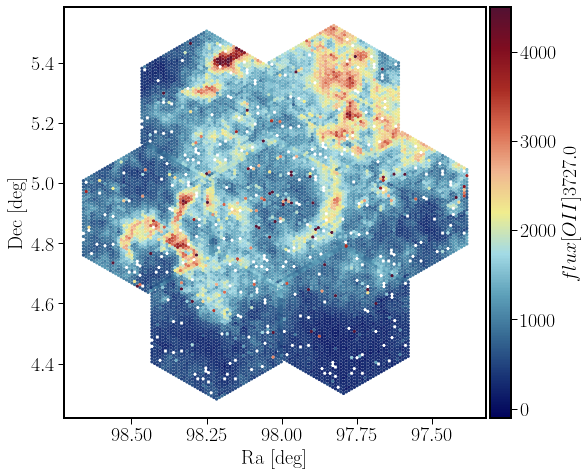

In [73]:
line='flux_[OII]_3727.0'
tab_line = Table()
tab_line['ra_fib']=tab_PT_all['ra'][tab_PT_all['mask']]
tab_line['dec_fib']=tab_PT_all['dec'][tab_PT_all['mask']]
tab_line['line']=tab_fe_all[line][tab_PT_all['mask']]
print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
title=line.replace("_"," ")
v_min=-np.nanmean(tab_line['line'])
v_max=5*np.nanstd(tab_line['line'])
print(v_min,v_max)
v_min=-100
v_max=4500
map_plot(tab_line, v_min, v_max, rf'${title}$', 'test_all', size=5,cmap=color_cm_now,fsize=8)

3.015126811907462 2.0149580855489697 5.185389898028616
-3.015126811907462 1.4204301248022184


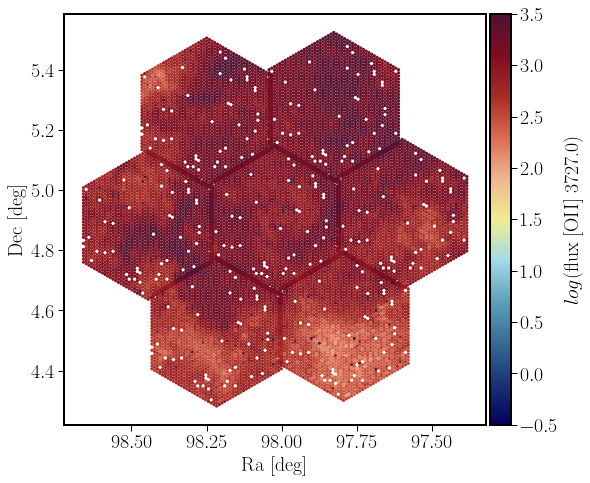

In [87]:
line='flux_[OII]_3727.0'
tab_line = Table()
tab_line['ra_fib']=tab_PT_all['ra'][tab_PT_all['mask']]
tab_line['dec_fib']=tab_PT_all['dec'][tab_PT_all['mask']]
tab_line['line']=np.log10(tab_fe_all[line][tab_PT_all['mask']])
print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
title=line.replace("_"," ")
v_min=-np.nanmean(tab_line['line'])
v_max=5*np.nanstd(tab_line['line'])
print(v_min,v_max)
v_min=-0.5
v_max=3.5
map_plot(tab_line, v_min, v_max, rf'log(${title}$)', 'test_all', size=5,cmap=color_cm_now,fsize=8)

In [74]:
el_names=tab_fe_all.columns[0:13]
print(el_names)

<TableColumns names=('flux_[OII]_3727.0','flux_Hd_4101.0','flux_Hg_4340.468','flux_Hb_4861.32','flux_[OIII]4959_4959.0','flux_[OIII]5007_5007.0','flux_Ha_6562.817','flux_[NII]6584_6583.6','flux_[NII]6548_6548.1','flux_[SII]6717_6716.47','flux_[SII]6731_6730.85','flux_[SIII]_9531.1','flux_[FeII]_9682.13')>


-1280.1968995328345 9386.051825853801


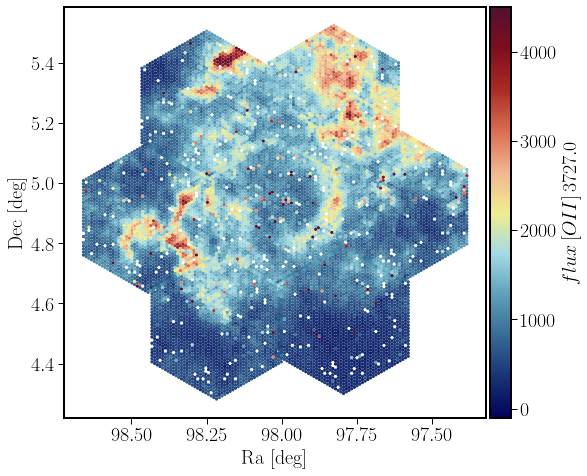

-383.74678801095905 6302.012128160122


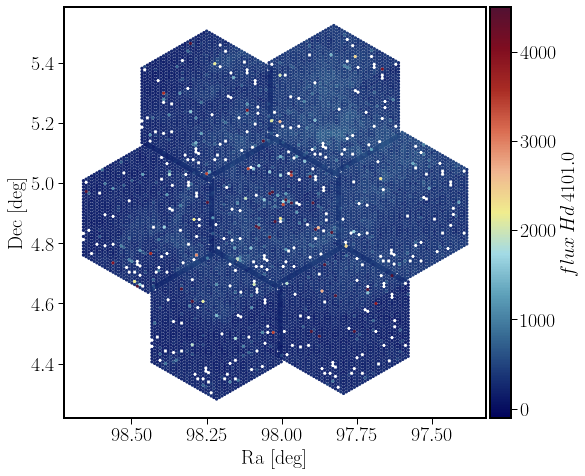

-515.3214471330841 5922.42750352444


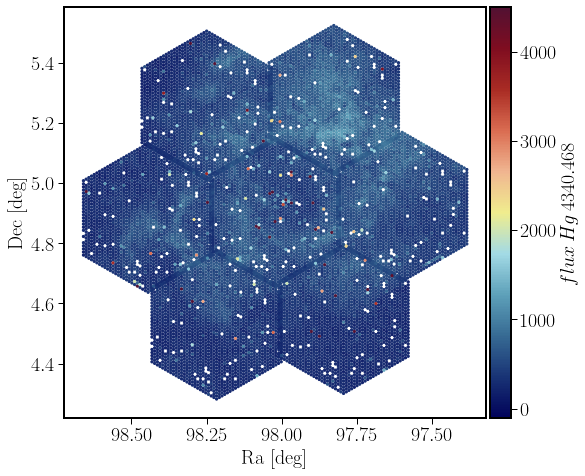

-929.5481573538195 5305.006933934452


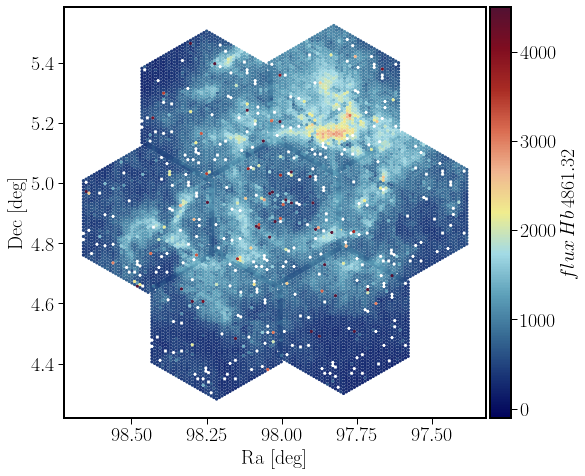

-533.5219791368461 5574.653802340458


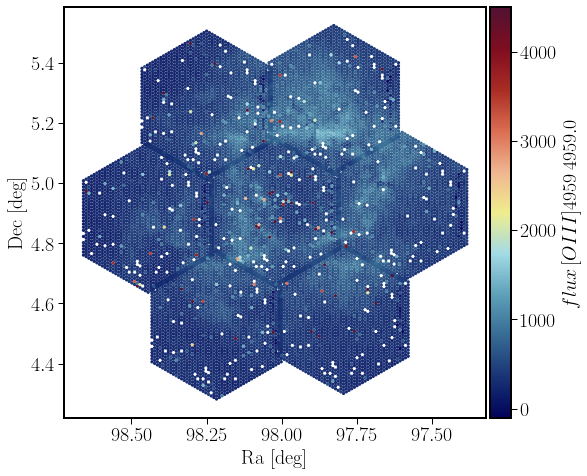

-1069.7178407840777 6615.308933050983


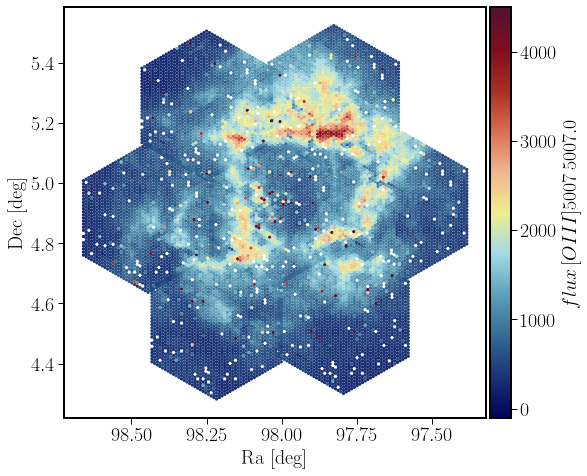

-3195.180672757959 9764.988481657672


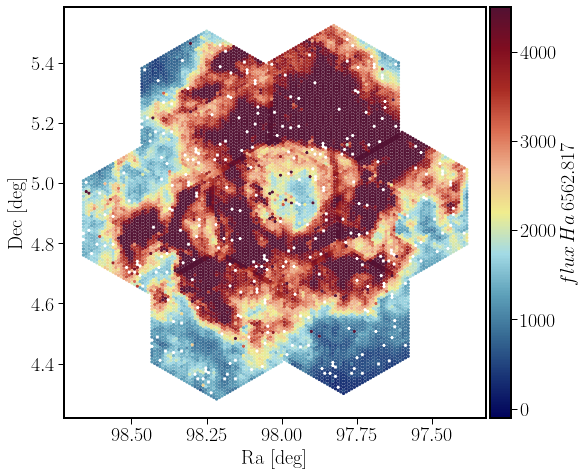

-907.3922867052001 6125.198847917733


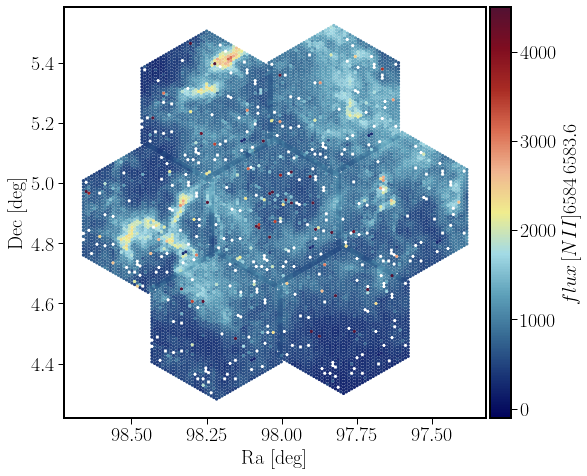

-446.18118410144575 6179.483814590942


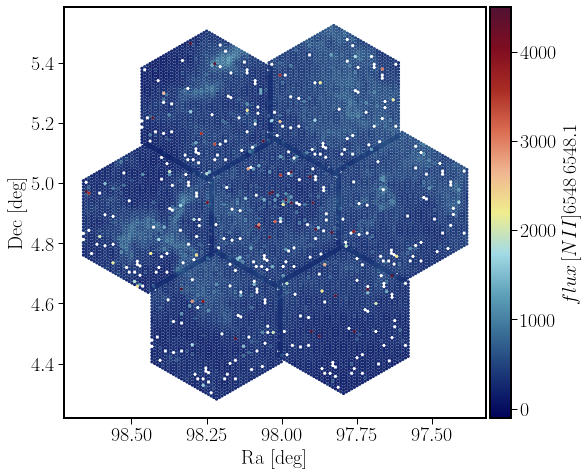

-500.10830833376383 4828.997225957186


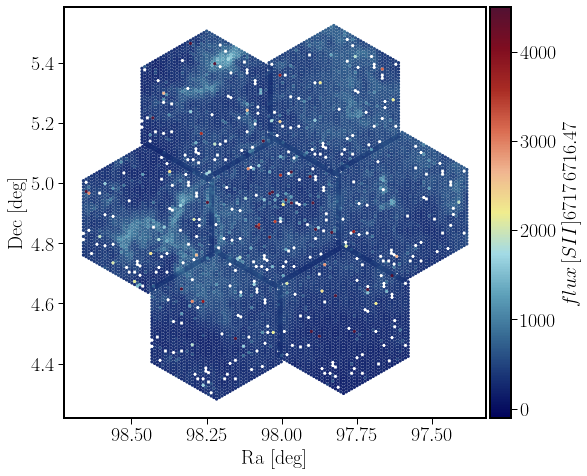

-417.08391007071674 4862.981066589462


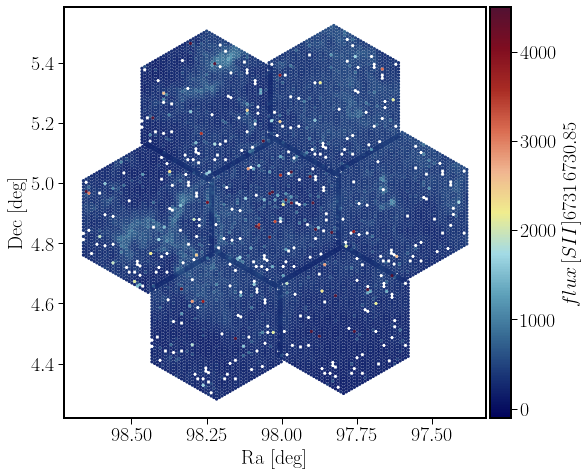

-1628.9597281195474 14158.464217562829


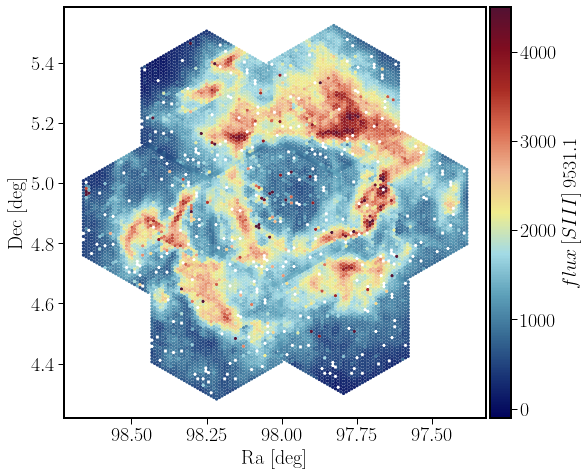

-18.87273625243416 18838.749229306028


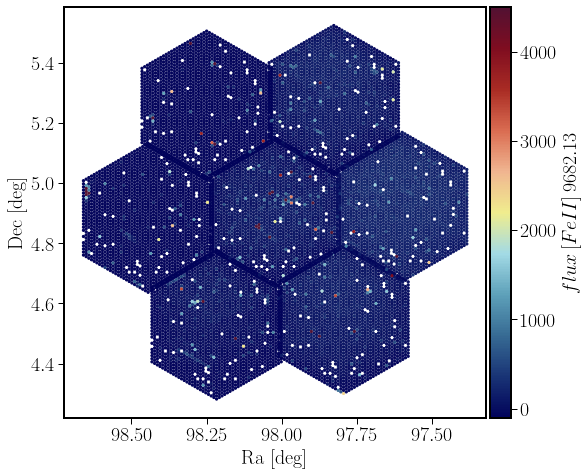

In [95]:
el_names=tab_fe_all.columns[0:13]
for line in el_names:
    tab_line = Table()
    tab_line['ra_fib']=tab_PT_all['ra'][tab_PT_all['mask']]
    tab_line['dec_fib']=tab_PT_all['dec'][tab_PT_all['mask']]
    tab_line['line']=tab_fe_all[line][tab_PT_all['mask']]
    title=line.replace("_","\,")
    v_min=-np.nanmean(tab_line['line'])
    v_max=5*np.nanstd(tab_line['line'])
    print(v_min,v_max)
    v_min=-100
    v_max=4500
    out_file=f'{line}.pdf'
    map_plot(tab_line, v_min, v_max, rf'${title}$', 'test_all', size=5,cmap=color_cm_now,fsize=8)

-1.66849020734952 -112.7903456820856 44.80922772860219


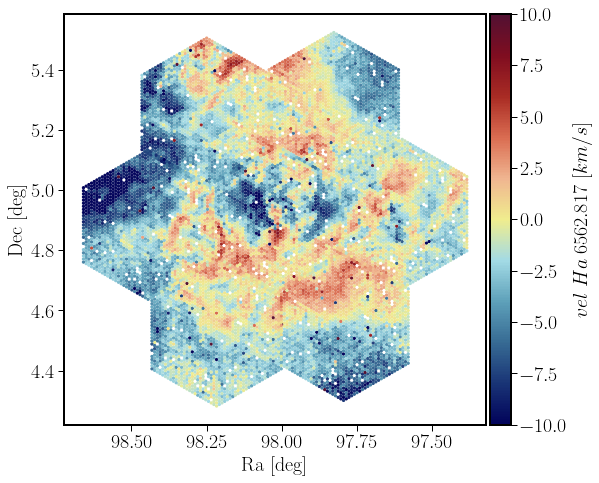

In [116]:
line='vel_Ha_6562.817'
tab_line = Table()
tab_line['ra_fib']=tab_PT_all['ra'][tab_PT_all['mask']]
tab_line['dec_fib']=tab_PT_all['dec'][tab_PT_all['mask']]
tab_line['line']=tab_fe_all[line][tab_PT_all['mask']]
print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
title=line.replace("_","\;")
v_min=-10
v_max=10
map_plot(tab_line, v_min, v_max, rf'${title}\; [km/s]$', 'vel_Ha_map', size=5,cmap=color_cm_now,fsize=8)

3195.180672757959 230.30217509666417 107249.78290009203
-3195.180672757959 9764.988481657672


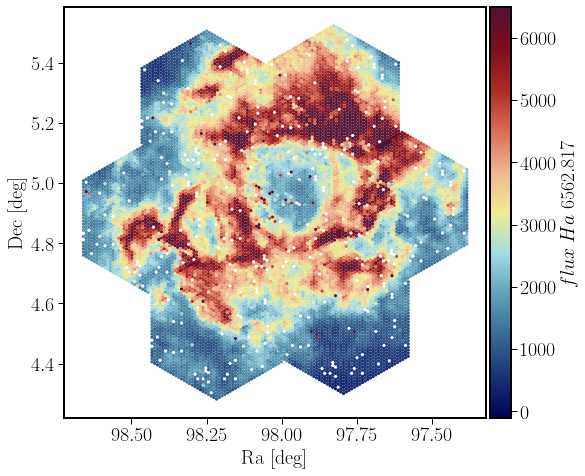

In [135]:
line='flux_Ha_6562.817'
tab_line = Table()
tab_line['ra_fib']=tab_PT_all['ra'][tab_PT_all['mask']]
tab_line['dec_fib']=tab_PT_all['dec'][tab_PT_all['mask']]
tab_line['line']=tab_fe_all[line][tab_PT_all['mask']]
print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
title=line.replace("_","\; ")
v_min=-np.nanmean(tab_line['line'])
v_max=5*np.nanstd(tab_line['line'])
print(v_min,v_max)
v_min=-100
v_max=6500
map_plot(tab_line, v_min, v_max, rf'${title}$', 'Ha_map', size=5,cmap=color_cm_now,fsize=8)

85.54472949819981 72.85093993052884 319.7147872685703
-85.54472949819981 49.75114033275677


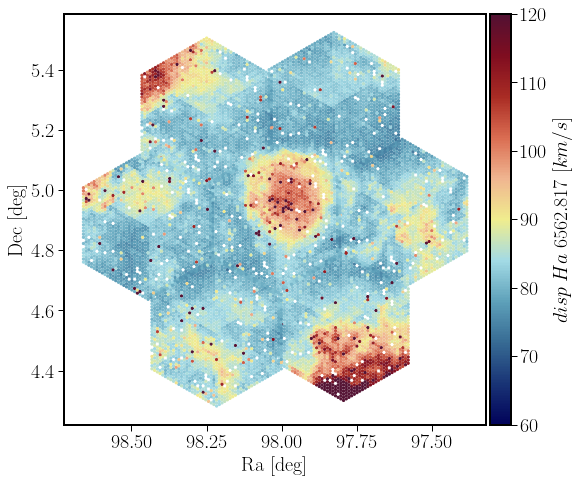

In [136]:
line='disp_Ha_6562.817'
tab_line = Table()
tab_line['ra_fib']=tab_PT_all['ra'][tab_PT_all['mask']]
tab_line['dec_fib']=tab_PT_all['dec'][tab_PT_all['mask']]
tab_line['line']=np.sqrt(np.abs(tab_fe_all[line][tab_PT_all['mask']]**2-6562/4000))*(300000/6562)
print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
title=line.replace("_","\;")
v_min=-np.nanmean(tab_line['line'])
v_max=5*np.nanstd(tab_line['line'])
print(v_min,v_max)
v_min=60
v_max=120
map_plot(tab_line, v_min, v_max, rf'${title}\; [km/s]$', 'disp_Ha_map', size=5,cmap=color_cm_now,fsize=8)

In [119]:
tab_fe=tab_fe_all
#,'flux_[SII]6717_6716.47','flux_[SII]6731_6730.85'
#<TableColumns names=('flux_[OII]_3727.0','flux_Hd_4101.0','flux_Hg_4340.468','flux_Hb_4861.32','flux_[OIII]4959_4959.0','flux_[OIII]5007_5007.0','flux_Ha_6562.817','flux_[NII]6584_6583.6','flux_[NII]6548_6548.1','flux_[SII]6717_6716.47','flux_[SII]6731_6730.85','flux_[SIII]_9531.1','flux_[FeII]_9682.13')>
flux_SII=tab_fe['flux_[SII]6731_6730.85']+tab_fe['flux_[SII]6717_6716.47']
e_flux_SII=tab_fe['e_flux_[SII]6731_6730.85']+tab_fe['e_flux_[SII]6731_6730.85']
tab_fe['flux_[SII]']=flux_SII
tab_fe['e_flux_[SII]']=e_flux_SII
rat_SII=tab_fe['flux_[SII]6717_6716.47']/tab_fe['flux_[SII]6731_6730.85']

Ha_Hb = tab_fe['flux_Ha_6562.817']/tab_fe['flux_Hb_4861.32']
O3=np.log10(tab_fe['flux_[OIII]5007_5007.0']/tab_fe['flux_Hb_4861.32'])
N2=np.log10(tab_fe['flux_[NII]6584_6583.6']/tab_fe['flux_Ha_6562.817'])
S2=np.log10(tab_fe['flux_[SII]']/tab_fe['flux_Ha_6562.817'])
#O1=np.log10(tab_fe['flux_[OI]_6300.3']/tab_fe['flux_Ha_6562.817'])
EW_Ha=np.log10(np.abs(tab_fe['flux_Ha_6562.817']))


<ipython-input-119-eac7148cf91f>:8: RuntimeWarning: invalid value encountered in true_divide
  rat_SII=tab_fe['flux_[SII]6717_6716.47']/tab_fe['flux_[SII]6731_6730.85']
<ipython-input-119-eac7148cf91f>:10: RuntimeWarning: invalid value encountered in true_divide
  Ha_Hb = tab_fe['flux_Ha_6562.817']/tab_fe['flux_Hb_4861.32']
<ipython-input-119-eac7148cf91f>:11: RuntimeWarning: invalid value encountered in true_divide
  O3=np.log10(tab_fe['flux_[OIII]5007_5007.0']/tab_fe['flux_Hb_4861.32'])
<ipython-input-119-eac7148cf91f>:11: RuntimeWarning: invalid value encountered in log10
  O3=np.log10(tab_fe['flux_[OIII]5007_5007.0']/tab_fe['flux_Hb_4861.32'])
<ipython-input-119-eac7148cf91f>:12: RuntimeWarning: invalid value encountered in true_divide
  N2=np.log10(tab_fe['flux_[NII]6584_6583.6']/tab_fe['flux_Ha_6562.817'])
<ipython-input-119-eac7148cf91f>:12: RuntimeWarning: invalid value encountered in log10
  N2=np.log10(tab_fe['flux_[NII]6584_6583.6']/tab_fe['flux_Ha_6562.817'])
<ipython-input

1.2120929354000802 0.3391175212415594 2.4505571611342076


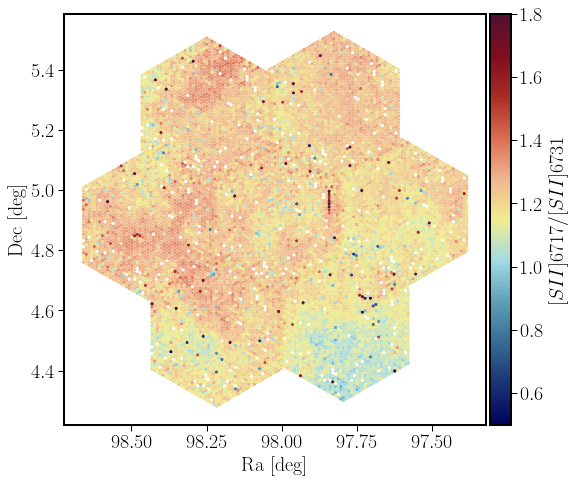

In [130]:
tab_line = Table()
tab_line['ra_fib']=tab_PT_all['ra'][tab_PT_all['mask']]
tab_line['dec_fib']=tab_PT_all['dec'][tab_PT_all['mask']]
tab_line['line']=rat_SII[tab_PT_all['mask']]
print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
title=line.replace("_","\; ")
v_min=0.5
v_max=1.8
map_plot(tab_line, v_min, v_max, rf'$[SII]6717/[SII]6731$', 'rat_SII_map', size=5,cmap=color_cm_now,fsize=8)

3.4680463993107478 0.5080529977271081 5.576139479507435


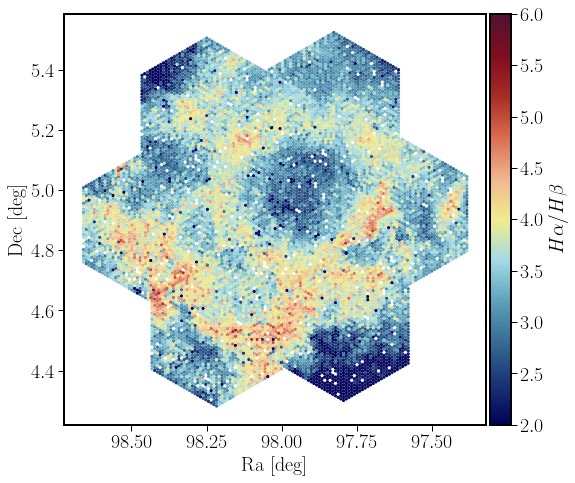

In [122]:
tab_line = Table()
tab_line['ra_fib']=tab_PT_all['ra'][tab_PT_all['mask']]
tab_line['dec_fib']=tab_PT_all['dec'][tab_PT_all['mask']]
tab_line['line']=Ha_Hb[tab_PT_all['mask']]
print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
title=line.replace("_","\; ")
v_min=2
v_max=6
map_plot(tab_line, v_min, v_max, rf'$H\alpha/H\beta$', 'Ha_Hb_map', size=5,cmap=color_cm_now,fsize=8)

-0.5305020084089438 -1.5178257504891715 0.09954929155697771


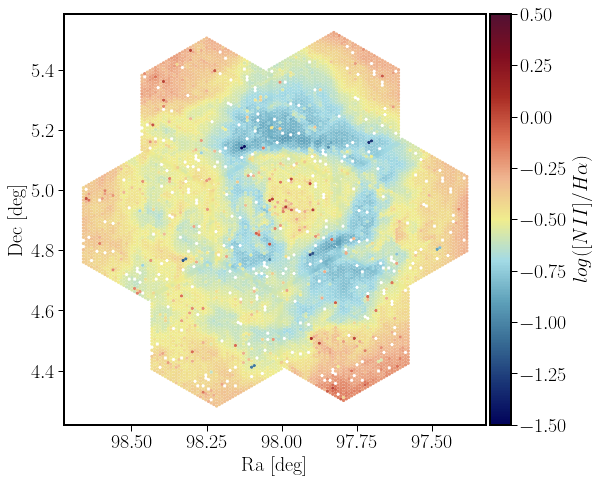

In [126]:
tab_line = Table()
tab_line['ra_fib']=tab_PT_all['ra'][tab_PT_all['mask']]
tab_line['dec_fib']=tab_PT_all['dec'][tab_PT_all['mask']]
tab_line['line']=N2[tab_PT_all['mask']]
print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
title=line.replace("_","\; ")
v_min=-1.5
v_max=0.5
map_plot(tab_line, v_min, v_max, rf'$log([NII]/H\alpha)$', 'N2_map', size=5,cmap=color_cm_now,fsize=8)

0.032407420268358834 -0.8306022618957554 0.772984666568437


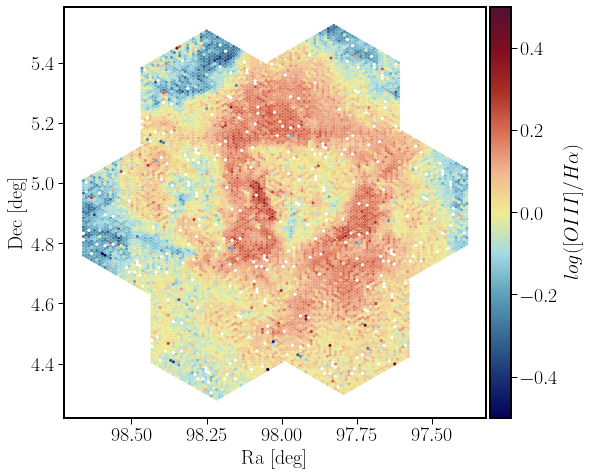

In [128]:
tab_line = Table()
tab_line['ra_fib']=tab_PT_all['ra'][tab_PT_all['mask']]
tab_line['dec_fib']=tab_PT_all['dec'][tab_PT_all['mask']]
tab_line['line']=O3[tab_PT_all['mask']]
print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
title=line.replace("_","\; ")
v_min=-0.5
v_max=0.5
map_plot(tab_line, v_min, v_max, rf'$log([OIII]/H\alpha)$', 'O3_map', size=5,cmap=color_cm_now,fsize=8)

3.4356258606739543 2.36229803969249 5.03039642173893
-3.4356258606739543 1.3041898615964609


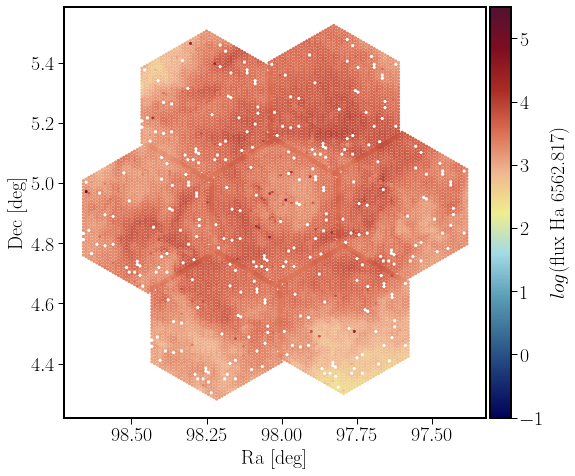

In [102]:
tab_line = Table()
tab_line['ra_fib']=tab_PT_all['ra'][tab_PT_all['mask']]
tab_line['dec_fib']=tab_PT_all['dec'][tab_PT_all['mask']]
tab_line['line']=np.log10(tab_fe_all[line][tab_PT_all['mask']])
print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
title=line.replace("_"," ")
v_min=-np.nanmean(tab_line['line'])
v_max=5*np.nanstd(tab_line['line'])
print(v_min,v_max)
v_min=-1
v_max=5.5
map_plot(tab_line, v_min, v_max, rf'log(${title}$)', 'log_Ha_map', size=5,cmap=color_cm_now,fsize=8)

In [138]:
def reverse_colourmap(cmap, name = 'my_cmap_r'):
    """
    In: 
    cmap, name 
    Out:
    my_cmap_r

    Explanation:
    t[0] goes from 0 to 1
    row i:   x  y0  y1 -> t[0] t[1] t[2]
                   /
                  /
    row i+1: x  y0  y1 -> t[n] t[1] t[2]

    so the inverse should do the same:
    row i+1: x  y1  y0 -> 1-t[0] t[2] t[1]
                   /
                  /
    row i:   x  y1  y0 -> 1-t[n] t[2] t[1]
    """        
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r


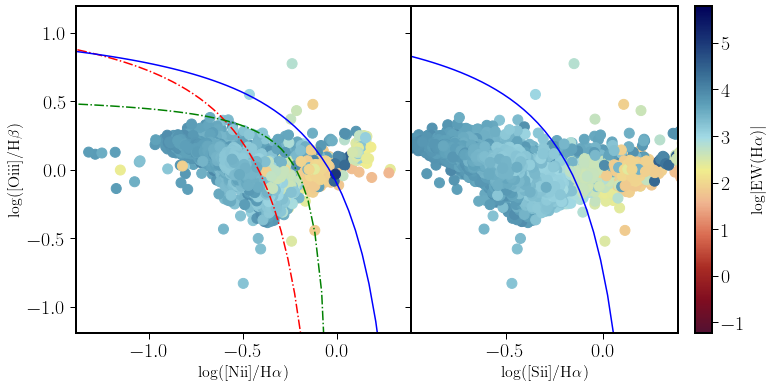

In [143]:
#
#
log_EW_Ha=EW_Ha
fig, axes = plt.subplots(1,2,figsize=(12,6), sharey=True, squeeze=False)
x_min1=-1.39
x_max1=0.39
y_min1=-1.19
y_max1=1.19

x=np.linspace(2*x_min1,2*x_max1,100)
cut_y=-0.7+0.2-3.67*x
cut_y2=-1.7+0.5-3.67*x
cut_y3=0.61/(x-0.05)+1.3
cut_y4=0.61/(x-0.47)+1.19
cut_y_SII=0.61/(x-0.3)+1.3;
cut_y_SII=0.61/(x-0.3)+1.3;
cut_y_SII_AGNs=1.89*(x)+0.76;
cut_y_OI=0.73/((x+0.59))+1.33;#+1.10;
cut_y_OI_AGNs=1.18*(x)+1.30;
cut_y_OIII_AGNs=1.14*(x)+0.36;

cut_CE=0.12579066/(x-0.00302777)+0.56846872

#axes[0,0].scatter(N2,O3,alpha=0.75, marker='*', s=100,c='green')
#axes[0,1].scatter(S2,O3,alpha=0.75, marker='*', s=100,c='green')
#axes[0,2].scatter(O1,O3,alpha=0.75, marker='*', s=100,c='green')

#cm='coolwarm_r'
cm=vel_map()
cm = reverse_colourmap(cm)
alpha=1.0
bpt1=axes[0,0].scatter(N2,O3,c=log_EW_Ha,vmin=0.78-2,vmax=0.78+5,cmap=cm,alpha=alpha, marker='o', s=100)
bpt2=axes[0,1].scatter(S2,O3,c=log_EW_Ha,vmin=0.78-2,vmax=0.78+5,cmap=cm,alpha=alpha, marker='o', s=100)

plt.colorbar(bpt1,label=r'log$|$EW(H$\alpha$)$|$')





#axes[0,0].scatter(N2_s,O3_s,alpha=0.85, marker='o', s=100,c='orange')

axes[0,0].plot(x[x<0],cut_y3[x<0],'r-.')
axes[0,0].plot(x[x<0],cut_CE[x<0],'g-.')
axes[0,0].plot(x,cut_y4,'b-')
axes[0,1].plot(x[x<0.1],cut_y_SII[x<0.1],'b-')


plt.rcParams.update({'font.size': 16})
axes[0,0].set_ylabel(r'log([Oiii]/H$\beta$)')
axes[0,0].set_xlabel(r'log([Nii]/H$\alpha$)')
axes[0,1].set_xlabel(r'log([Sii]/H$\alpha$)')
axes[0,0].set_xlim(x_min1,x_max1)
axes[0,1].set_xlim(x_min1+0.4,x_max1)
axes[0,0].set_ylim(y_min1,y_max1)
plt.subplots_adjust(wspace=0)

In [144]:
C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])
print(C.shape)


flux_SII=tab_fe['flux_[SII]6731_6730.85']+tab_fe['flux_[SII]6717_6716.47']
e_flux_SII=tab_fe['e_flux_[SII]6731_6730.85']+tab_fe['e_flux_[SII]6731_6730.85']
tab_fe['flux_[SII]']=flux_SII
tab_fe['e_flux_[SII]']=e_flux_SII
rat_SII=tab_fe['flux_[SII]6717_6716.47']/tab_fe['flux_[SII]6731_6730.85']

Rc =  tab_fe['flux_Ha_6562.817']-tab_fe['']


/tab_fe['flux_Hb_4861.32']
O3=np.log10(tab_fe['flux_[OIII]5007_5007.0']/tab_fe['flux_Hb_4861.32'])
N2=np.log10(tab_fe['flux_[NII]6584_6583.6']/tab_fe['flux_Ha_6562.817'])
S2=np.log10(tab_fe['flux_[SII]']/tab_fe['flux_Ha_6562.817'])
#O1=np.log10(tab_fe['flux_[OI]_6300.3']/tab_fe['flux_Ha_6562.817'])
EW_Ha=np.log10(np.abs(tab_fe['flux_Ha_6562.817']))



(3, 3)


In [ ]:
tab_line = Table()
tab_line['ra_fib']=tab_PT_all['ra'][tab_PT_all['mask']]
tab_line['dec_fib']=tab_PT_all['dec'][tab_PT_all['mask']]
R=

C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])

tab_line['line']=np.log10(tab_fe_all[line][tab_PT_all['mask']])
print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
title=line.replace("_"," ")
v_min=-np.nanmean(tab_line['line'])
v_max=5*np.nanstd(tab_line['line'])
print(v_min,v_max)
v_min=-1
v_max=5.5
map_plot(tab_line, v_min, v_max, rf'log(${title}$)', 'rgb_map', size=5,cmap=color_cm_now,fsize=8)